# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are 2 main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Fri Aug 26 08:56:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and become one with data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-26 08:56:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   138MB/s    in 1.2s    

2022-08-26 08:56:03 (138 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We're use the `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckPoint callback
* Stoping a model from training  (before it trains too long and overfits) with the EarlyStopping callback.

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'2.8.2'

In [7]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  # set up variable 
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we're created above is only one option.

## Creating models using TensorFlow Hub

In the past we're used TensorFlow to create our own models layer by layer from scratch.

Now we#re going to do similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access preraind models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1



In [9]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"



In [10]:
# Import dependencies
import tensorflow_hub as hub 
from tensorflow.keras import layers 

In [14]:
from tensorflow_hub import feature_column
# Let's make a created_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equsl to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,)) # freese the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and Testing ResNet TesnorFlow Hub Feature Extraction model

In [15]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [17]:
# Compile our Resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [19]:
# Let's fit our ResNet model to the data (10 percent of 10 classe)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20220826-093251
Epoch 1/5
24/24 [==============================] - 33s 759ms/step - loss: 1.9274 - accuracy: 0.3827 - val_loss: 1.1858 - val_accuracy: 0.6332
Epoch 2/5
24/24 [==============================] - 17s 711ms/step - loss: 0.8963 - accuracy: 0.7413 - val_loss: 0.8392 - val_accuracy: 0.7468
Epoch 3/5
24/24 [==============================] - 17s 708ms/step - loss: 0.6125 - accuracy: 0.8427 - val_loss: 0.7435 - val_accuracy: 0.7752
Epoch 4/5
24/24 [==============================] - 17s 709ms/step - loss: 0.4724 - accuracy: 0.8787 - val_loss: 0.6961 - val_accuracy: 0.7820
Epoch 5/5
24/24 [==============================] - 16s 703ms/step - loss: 0.3702 - accuracy: 0.9160 - val_loss: 0.6787 - val_accuracy: 0.7836


In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Wow !!!

That is incredible ... Our transfer learning feature extractor model out performed ALL of the previous models we built by hands ... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [22]:
# Let's create a function to plot our loss curves ...
# Tip: you could put a function like this into a script called "helper.py"
# and import it when you need it.
import matplotlib.pyplot as plt 

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Arg:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]  

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

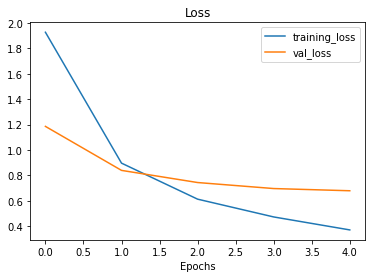

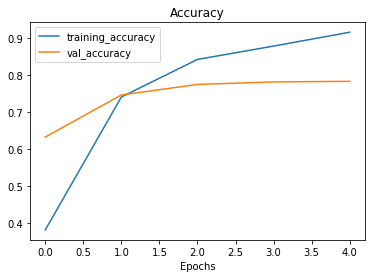

In [23]:
plot_loss_curves(resnet_history)

### Creating and Testing EfficientNetB0 TensorFolw Hub Feature Extraction model


Details on efficientNet:
https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

In [31]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)


In [32]:
# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [33]:
# Fit the EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientNetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientNetB0/20220826-102715
Epoch 1/5
24/24 [==============================] - 25s 709ms/step - loss: 1.8067 - accuracy: 0.4533 - val_loss: 1.2723 - val_accuracy: 0.7276
Epoch 2/5
24/24 [==============================] - 15s 665ms/step - loss: 1.0399 - accuracy: 0.7760 - val_loss: 0.8657 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 16s 668ms/step - loss: 0.7473 - accuracy: 0.8373 - val_loss: 0.6961 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 15s 664ms/step - loss: 0.6016 - accuracy: 0.8627 - val_loss: 0.6115 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 16s 669ms/step - loss: 0.5071 - accuracy: 0.8933 - val_loss: 0.5597 - val_accuracy: 0.8656


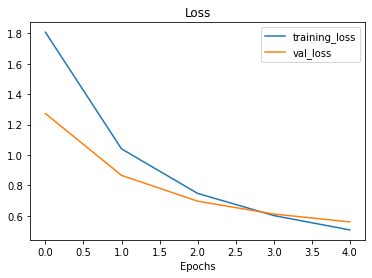

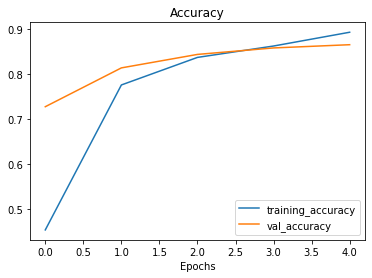

In [34]:
plot_loss_curves(efficientnet_history)